# 문자를 읽을 수 있는 딥러닝
다양한 OCR모델 비교하기

## Step1. 검증용 데이터셋 준비

In [1]:
import os
import glob

path = os.getenv('HOME')+'/aiffel/ocr_python/Test_Images/*'

images = glob.glob(path)
images_path = [image for image in images if image.endswith('.png')]

images_path

['/aiffel/aiffel/ocr_python/Test_Images/3.png',
 '/aiffel/aiffel/ocr_python/Test_Images/1.png',
 '/aiffel/aiffel/ocr_python/Test_Images/2.png']

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### 1. Google OCR API

In [2]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [3]:
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

for image in images_path:
    print(image)
    detect_text(image)

total 1352
-rw-r--r-- 1 root root   5609 Sep 17 17:21 0000.png
-rw-r--r-- 1 root root   5024 Sep 17 17:21 0001.png
-rw-r--r-- 1 root root   6240 Sep 17 17:21 0002.png
-rw-r--r-- 1 root root   7314 Sep 17 17:21 0003.png
-rw-r--r-- 1 root root   5498 Sep 17 17:21 0004.png
-rw-r--r-- 1 root root   7424 Sep 17 17:21 0005.png
-rw-r--r-- 1 root root   7962 Sep 17 17:21 0006.png
-rw-r--r-- 1 root root   5185 Sep 17 17:21 0007.png
-rw-r--r-- 1 root root   8077 Sep 17 17:21 0008.png
-rw-r--r-- 1 root root   3850 Sep 17 17:21 0009.png
-rw-r--r-- 1 root root   5194 Sep 17 17:21 0010.png
-rw-r--r-- 1 root root   4173 Sep 17 17:21 0011.png
-rw-r--r-- 1 root root   8251 Sep 17 17:21 0012.png
-rw-r--r-- 1 root root   5637 Sep 17 17:21 0013.png
-rw-r--r-- 1 root root   5454 Sep 17 17:21 0014.png
-rw-r--r-- 1 root root   3455 Sep 17 17:21 0015.png
-rw-r--r-- 1 root root   8359 Sep 17 17:21 0016.png
-rw-r--r-- 1 root root   3460 Sep 17 17:21 0017.png
-rw-r--r-- 1 root root   7332 Sep 17 17:21 0018.png
-

### 2. keras-ocr

In [4]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
images = [ keras_ocr.tools.read(image) for image in images_path]
prediction_groups = [pipeline.recognize([image]) for image in images_path]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


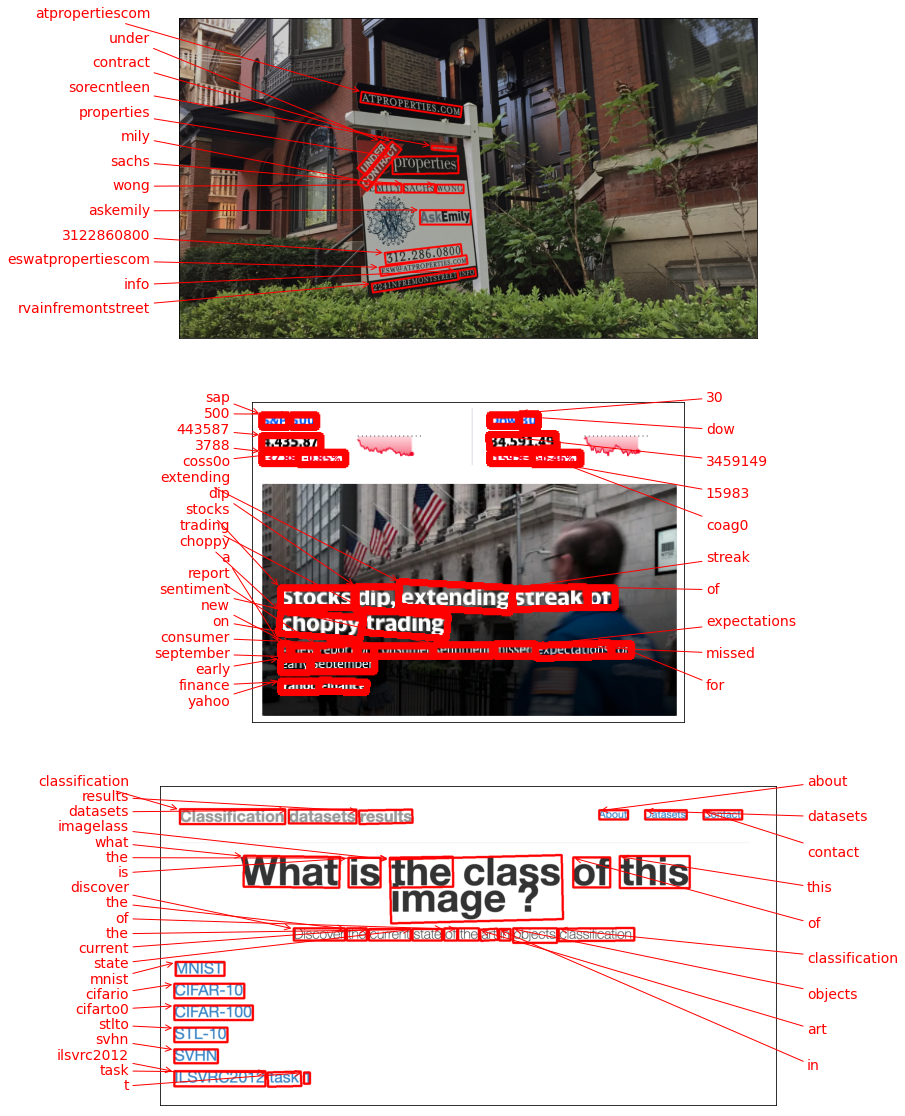

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(
        image=images[idx], predictions=prediction_groups[idx][0], ax=ax)

### 3. Tesseract

In [8]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/Test_Images/work'

for image in images_path:
    cropped_image_path_list = crop_word_regions(image, work_dir)

/aiffel/aiffel/ocr_python/Test_Images/work/0000.png
/aiffel/aiffel/ocr_python/Test_Images/work/0001.png
/aiffel/aiffel/ocr_python/Test_Images/work/0002.png
/aiffel/aiffel/ocr_python/Test_Images/work/0003.png
/aiffel/aiffel/ocr_python/Test_Images/work/0004.png
/aiffel/aiffel/ocr_python/Test_Images/work/0005.png
/aiffel/aiffel/ocr_python/Test_Images/work/0006.png
/aiffel/aiffel/ocr_python/Test_Images/work/0007.png
/aiffel/aiffel/ocr_python/Test_Images/work/0008.png
/aiffel/aiffel/ocr_python/Test_Images/work/0009.png
/aiffel/aiffel/ocr_python/Test_Images/work/0010.png
/aiffel/aiffel/ocr_python/Test_Images/work/0011.png
/aiffel/aiffel/ocr_python/Test_Images/work/0012.png
/aiffel/aiffel/ocr_python/Test_Images/work/0013.png
/aiffel/aiffel/ocr_python/Test_Images/work/0014.png
/aiffel/aiffel/ocr_python/Test_Images/work/0015.png
/aiffel/aiffel/ocr_python/Test_Images/work/0016.png
/aiffel/aiffel/ocr_python/Test_Images/work/0017.png
/aiffel/aiffel/ocr_python/Test_Images/work/0018.png
/aiffel/aiff

In [9]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

Classification

gqatasets

results

Apnpout

LJatasets

Contact

Wha

tis

the

clags

of

this

Image

a

| ISCOVve

r tne

Current

state

OT

ine

ort

la

objects

classiication.

MNIST

CIFAR-10

CIFAR-100

STL-10

SVHN

ILSVRC2012

task

1

Done


## Step3. 테스트 결과 정리

## Step4. 결과 분석과 결론 제시